In [20]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Chicago data

Now with KDE for time and space _combined_.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_grid
import sepp.sepp_grid_space
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")
open_cp.logger.log_to_true_stdout()
import open_cp.sources.chicago
import open_cp.geometry
import open_cp.evaluation
import descartes
import pickle, lzma, datetime, collections, os
import open_cp.predictors
#import open_cp.kernels
import scipy.stats
import sepp.kernels

In [22]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    all_points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

In [23]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [24]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

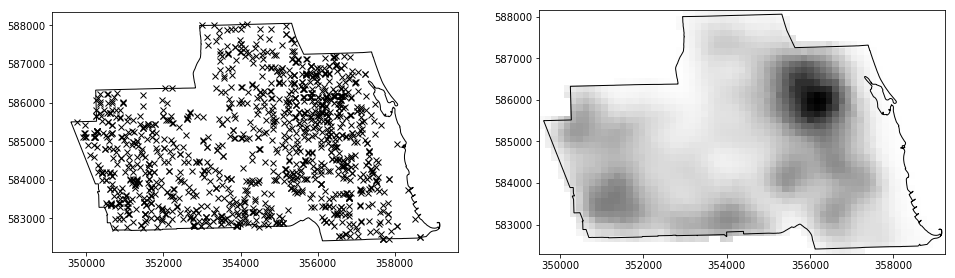

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
_pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*_pred.mesh_data(), _pred.intensity_matrix, cmap="Greys", rasterized=True)
None

## Some visualisation code

In [30]:
def compute_plot_kde(ker, size):
    x = np.linspace(-size, size, 151)
    y = x
    xcs, ycs = np.meshgrid(x, y)
    z = ker([xcs.flatten(), ycs.flatten()])
    z = z.reshape(xcs.shape)
    return x, y, z

def plot_kde(ax, ker, size, postprocess=None):
    x, y, z = compute_plot_kde(ker, size)
    if postprocess is not None:
        z = postprocess(z)
    return ax.pcolorfast(x,y,z, cmap="Greys", rasterized=True)

def backup_limits(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    return xmin, xmax, ymin, ymax

def set_limits(ax, xmin, xmax, ymin, ymax):
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

def pp(x):
    return np.log(np.exp(-20)+x)

def plot(model, time_size=100, space_size=400):
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    ax = axes[0]
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)
    bpred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)
    m = ax.pcolor(*bpred.mesh_data(), bpred.intensity_matrix, cmap="Greys", rasterized=True)
    cb = fig.colorbar(m, ax=ax)
    ax.set_title("Background rate")
    
    ax = axes[1]
    t_marginal = sepp.kernels.compute_t_marginal(model.trigger_kernel)
    xy_marginal = sepp.kernels.compute_space_marginal(model.trigger_kernel)
    
    times = np.linspace(0, time_size, 100)
    y = t_marginal(times) * model.theta
    ax.plot(times, y, color="black")
    ax.set(xlabel="days", ylabel="Trigger risk", title="Marginal time distribution")
    omega = 1 / np.sum(y * times * (times[1] - times[0]) / model.theta)
    ax.plot(times, np.exp(-times * omega) * omega * model.theta, color="black", linewidth=1, linestyle="--")
    y = np.max(y)
    for t in range(0, time_size+1):
        ax.plot([t,t],[0,y], color="grey", linewidth=0.5, linestyle="--", zorder=-10)
    
    plot_kde(axes[2], xy_marginal, space_size, pp)
    axes[2].set_title("Marginal space distribution")
    
    fig.tight_layout()
    return fig

def scatter_triggers(trainer, model, predict_time):
    backgrounds, trigger_deltas = trainer.sample_to_points(model, predict_time)
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    def add_kde(ax, pts):
        xmin, xmax, ymin, ymax = backup_limits(ax)
        x = np.linspace(xmin, xmax, 151)
        y = np.linspace(ymin, ymax, 151)
        xcs, ycs = np.meshgrid(x, y)
        ker = scipy.stats.kde.gaussian_kde(pts)
        z = ker([xcs.flatten(), ycs.flatten()])
        z = z.reshape(xcs.shape)
        z = np.log(np.exp(-15)+z)
        m = ax.pcolorfast(x,y,z, cmap="Greys", rasterized=True, alpha=0.7, zorder=-10)

    ax = axes[0]
    pts = trigger_deltas[1:]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set_title("Space trigger points")

    ax = axes[1]
    pts = trigger_deltas[[0,1]]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set(xlabel="days", ylabel="x coord")#, xlim=[0,200])

    ax = axes[2]
    pts = trigger_deltas[[0,2]]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set(xlabel="days", ylabel="y coord")

    fig.tight_layout()
    return fig, backgrounds, trigger_deltas

## Fixed bandwidth

In [27]:
kp = sepp.kernels.FixedBandwidthKernelProvider(1, scale=(1,20,20))
trainer = sepp.sepp_grid_space.Trainer5(grid, kp, p_cutoff=99.99, initial_space_scale=100)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model5(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.8780430412424234, trigger=<open_cp.kernels.ReflectedKernel object at 0x000001F337B33320>

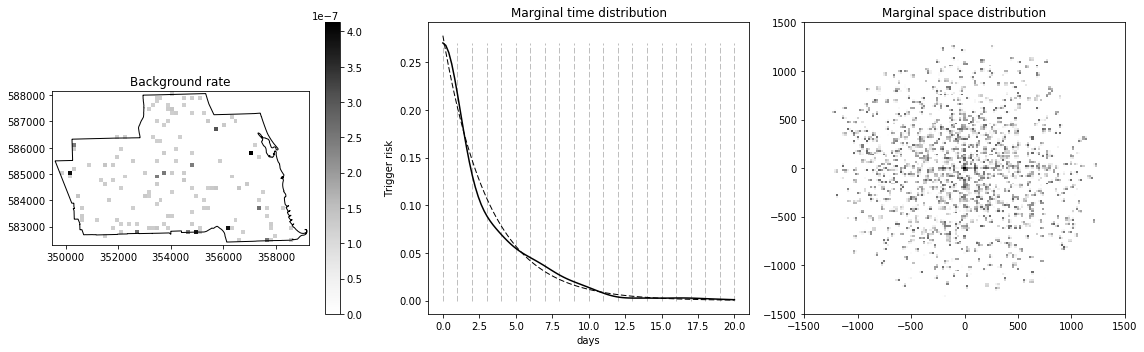

In [33]:
fig = plot(model, 20, 1500)

In [34]:
fig.savefig("../full_kde_1.pdf")

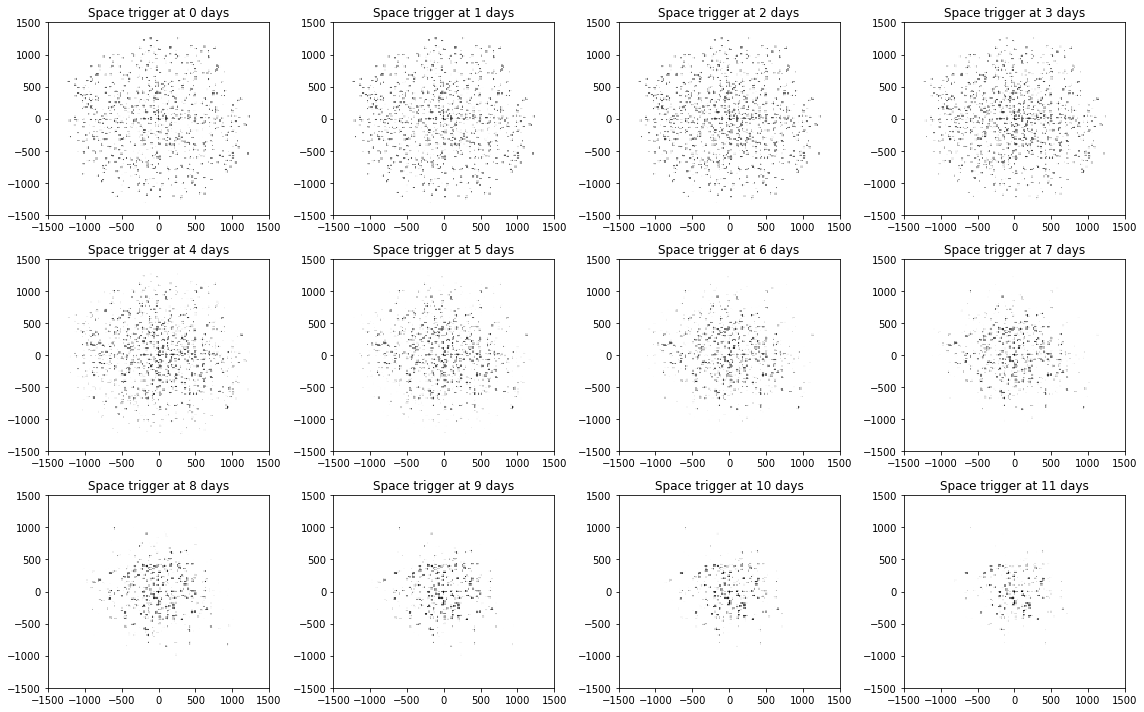

In [39]:
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(16,10))

t_marginal = sepp.kernels.compute_t_marginal(model.trigger_kernel)
for ax, t in zip(axes.flat, range(0,12)):
    def ker(x):
        x = np.asarray(x)
        w = t_marginal(t)
        return model.trigger_kernel([[t]*x.shape[-1],x[0],x[1]]) / w
    plot_kde(ax, ker, 1500, pp)
    ax.set_title("Space trigger at {} days".format(t))
    
fig.tight_layout()

In [40]:
fig.savefig("../full_kde_2.pdf")

((3, 149), (3, 1080))

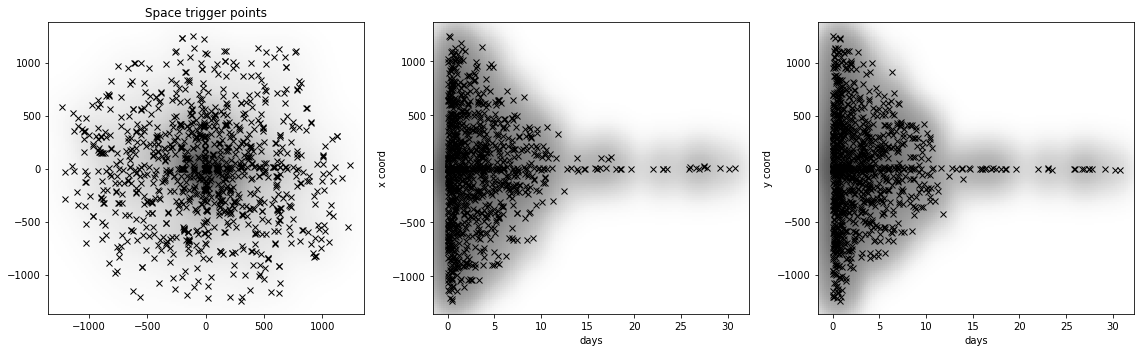

In [37]:
fig, back, trig = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))
back.shape, trig.shape

In [38]:
fig.savefig("../full_kde_3.pdf")